## Analysis of OneStep sgRNA library

### Load libraries and functions

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import time
import fcsparser as fcs
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
sns.set(style ="whitegrid")
sns.set_context("poster")
warnings.filterwarnings("once")
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette('Pastel2', 4).as_hex())

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    for index, item in enumerate(Z):
        if  (item == '3C + NT'):
            Z[index] = 0
        elif (item == '3C + Red'):
            Z[index] = 1
        elif (item == '3C + Blue'):
            Z[index] = 2
        else:
            Z[index] = 3
    Z = Z.reshape(xx.shape)
    
    
    out = ax.contourf(xx, yy, Z, 3, **params)
    return out

#functions for distribution plot
def multiple_dist_plot (dfx, FP, start):
    
    sns.set(style="white", font_scale=1, font="Arial", rc={"axes.facecolor": (0, 0, 0, 0)})
    sns.set_context("notebook")
    order = list(dfx.groupby(by=["Info"])[FP].aggregate(np.median).sort_values().iloc[::].index)
    if isinstance(start, str)==True:
        pal = sns.color_palette( start, len(order))
    else:
        pal = sns.cubehelix_palette(len(order), start=start)
    #pal.reverse()    
    #pal_order=[]
    #original_order=list(dfx.Info.unique())
    #for i in np.arange(len(order)):
    #    pal_order.append(order.index(original_order[i]))
    #pal=np.array(pal)
    #pal=pal[pal_order]
    
    g = sns.FacetGrid(dfx, row="Info", hue="Info", aspect=10, size=.5, palette=pal)#, row_order=order)

    # Draw the densities in a few steps
    #g.map(sns.distplot, FP)
    g.map(sns.kdeplot, FP, clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2, color='gray')
    g.map(sns.kdeplot, FP, clip_on=False, color="w", lw=2, bw=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False, color ='gray')

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        #ax.text(0, .2, [label,np.round(np.median(x), decimals=2)], fontweight="bold", color=color, 
                #ha="left", va="center", transform=ax.transAxes)
        ax.text(0, .2, label, fontweight="bold", color='gray', 
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, FP)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    

    
# define function to plot classification report    
def plot_classification_report(y_tru, y_prd, fname, figsize=(5, 5), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    xticks = ['precision', 'recall', 'f1-score']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep[[1,2,0,3,4], :-1],
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=['3C + NT','3C + Red', '3C + Blue','3C+ Blue + Red', 'Average'],
                ax=ax)
    plt.savefig(folder + fname +'.eps', type = 'eps')
    plt.savefig(folder + fname +'.png', type = 'png', dpi=300)

### Load files and metadata

In [ ]:
#folder with fcs files in subfolders
folder="C:\\FCS_experiment\\"

ffolderlist = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]


df=pd.DataFrame()
aa=1

#load all fcs files
for fdn in ffolderlist:
    ffilelist = os.listdir(folder+fdn)
    print (fdn)
    plate = fdn.split("_")[2]
    run = fdn.split("_")[3]
    for fn in ffilelist:
        filename, file_ext = os.path.splitext(fn)
        if file_ext ==".fcs":
            path = folder + fdn + "//" + fn
            meta, df1 = fcs.parse(path, meta_data_only=False, reformat_meta=True)
            df1["WellName"]=fn.split("_")[3].split(".")[0]
            df1["WellNumber"]= aa
            df1["Plate"] =plate
            df1["Run"] = run
            df=df.append(df1)
            aa=aa+1

# metadata file
meta = "C:\\metadata.csv"
df1=pd.read_csv(meta, names=["WellName", "Name", "ExperimentName", "Info", "Plate"], dtype= object)

dfnew=df1.merge(df, on=["WellName", "Plate"])

### remove zeros, gate live cells and log data

In [ ]:
#remove zeros
dfnew= dfnew[dfnew > 0]

#remove doublets
dfnew["doublet"] = dfnew["FSC-A"] / dfnew["FSC-H"]
df2=dfnew[(dfnew.doublet < 2)& (dfnew.doublet > 1.25)]
df2=dfnew

#remove small events
df2 =df2[df2["FSC-A"]>0E5]
df2 =df2[(df2["SSC-A"]<2E5)]

#show data for first well
g = sns.jointplot("FSC-A", "SSC-A", data=df2[df2["WellNumber"]==1], s=1)#.plot_joint(sns.kdeplot, zorder=0, n_levels=6);
plt.show()

#log data
for col in df2.columns:
    if df2[col].dtype=="float32":
        df2["log"+ col]=df2[col].apply(math.log10)


### gate cells that express circuit

In [ ]:
df3=df2[(df2['logAPC-Cy7-A']>2.5)  & (df2['logFITC-A']>1.8) & (df2['logFITC-A']<2.5)] # choose only Texas Red positive cells

### plot scatter plots

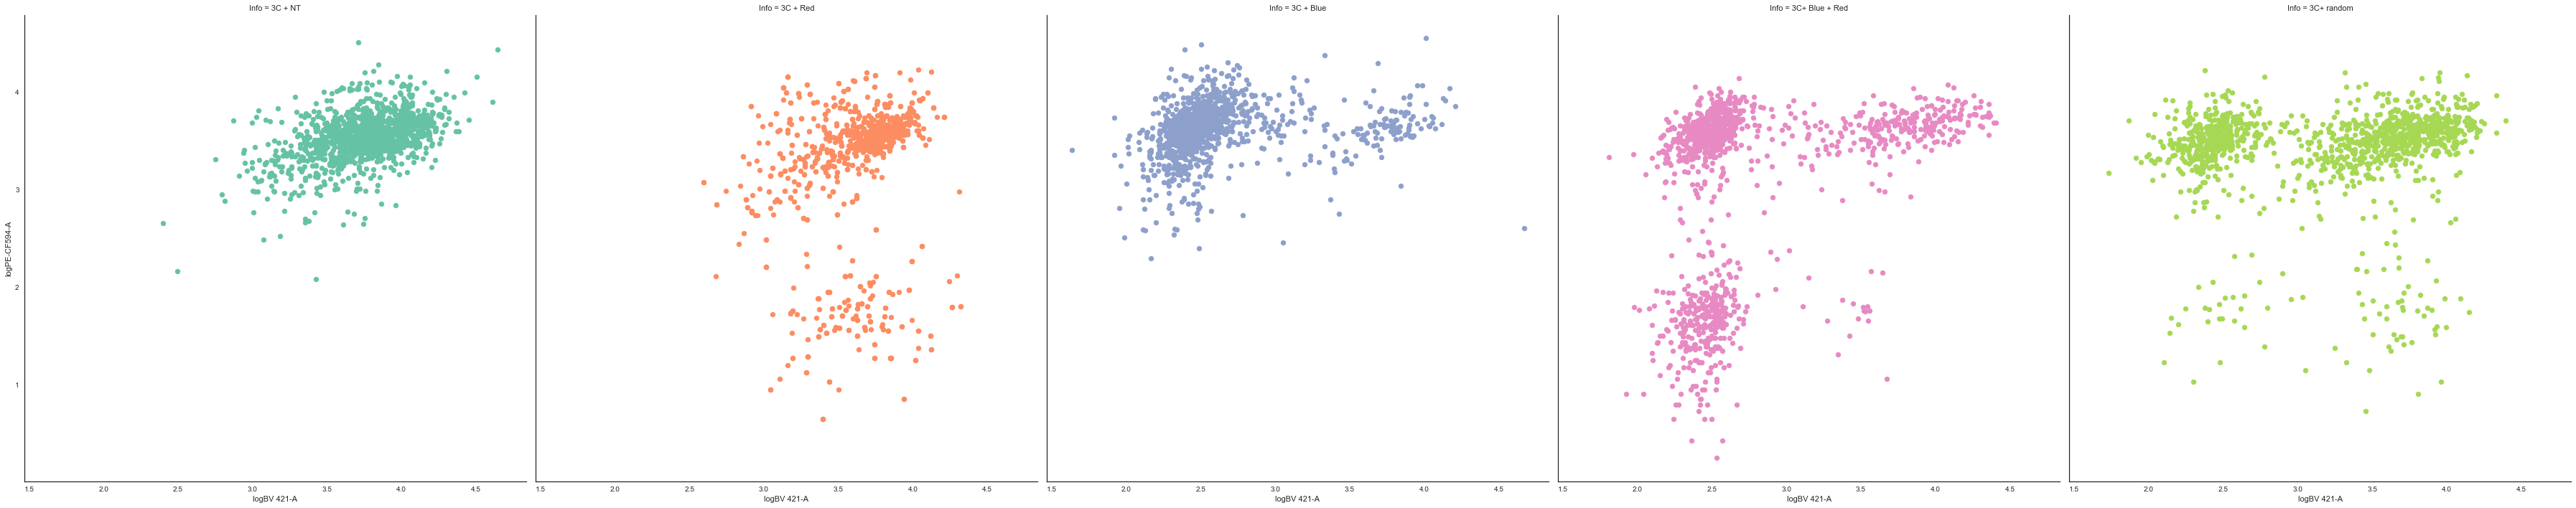

In [33]:
g=sns.FacetGrid(col = "Info",hue = "Info", data = df3, palette='Set2',
                col_order =['3C + NT','3C + Red', '3C + Blue','3C+ Blue + Red', "3C+ random"], size =10)
g=g.map(plt.scatter, "logBV 421-A", "logPE-CF594-A", s=50)
plt.savefig(folder + 'scatter.eps', type ='eps')
plt.savefig(folder + 'scatter.png', type ='png', dpi =300)
plt.show()





### prepare df for SVM training

In [ ]:
dftest = df3[df3["Info"]=="3C + NT"].sample(1250)
dftest = dftest.append(df3[df3["Info"]=="3C + Red"].sample(1250))
dftest = dftest.append(df3[df3["Info"]=="3C + Blue"].sample(1250))
dftest = dftest.append(df3[df3["Info"]=="3C+ Blue + Red"].sample(1250))

dftest["Zcat"] = dftest["Name"].astype('category')
dftest["Zcat"] = dftest["Zcat"].cat.codes


### Train SVM

In [34]:
start = time.time()
X = dftest.loc[:, ["logBV 421-A", "logPE-CF594-A"]]
y=dftest['Info']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 
svclassifier = LinearSVC(C=1)  
svclassifier.fit(X_train, y_train)
end = time.time()
print(end - start)

0.8636913299560547


### Report confusion matrix and classification report

[[218  23   2  10]
 [  2 193  19   8]
 [ 12 164  71  18]
 [127  47   5  81]]
                precision    recall  f1-score   support

     3C + Blue       0.61      0.86      0.71       253
       3C + NT       0.45      0.87      0.59       222
      3C + Red       0.73      0.27      0.39       265
3C+ Blue + Red       0.69      0.31      0.43       260

   avg / total       0.63      0.56      0.53      1000

0.009974002838134766


Info
3C + Blue         2
3C + NT           0
3C + Red          1
3C+ Blue + Red    3
Name: Zcat, dtype: int8

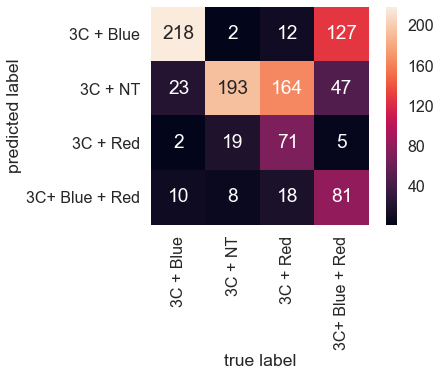

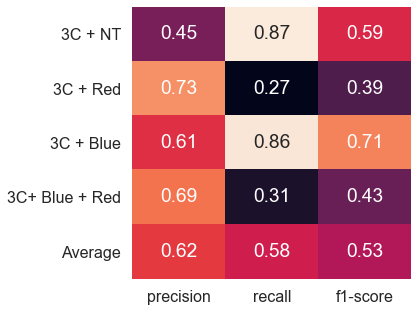

In [44]:
y_pred = svclassifier.predict(X_test)  
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, xticklabels=[ '3C + Blue','3C + NT','3C + Red','3C+ Blue + Red']
            , yticklabels=[ '3C + Blue','3C + NT','3C + Red','3C+ Blue + Red'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig(folder + 'SVM_confusionmatrix.eps', type = 'eps')
plt.savefig(folder + 'SVM_confusionmatrix.png', type = 'png', dpi=300)



plot_classification_report(y_test,y_pred, 'SVM_classificationreport')

### plot SVM area + scatter

<Figure size 432x288 with 0 Axes>

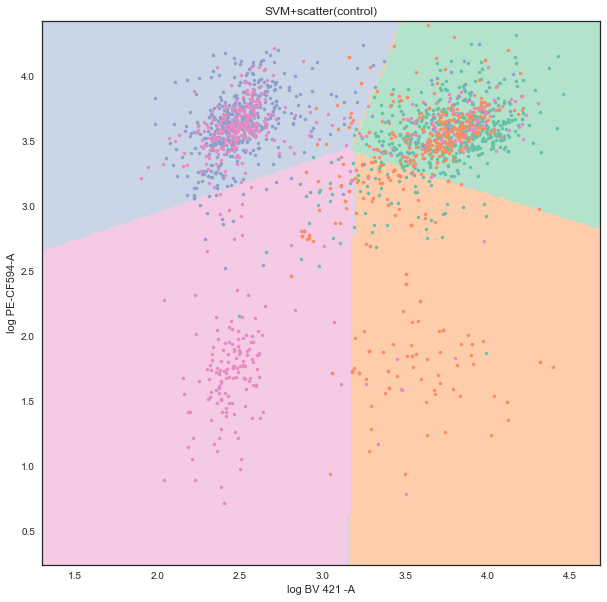

In [38]:
sns.set_palette('Set2')
plt.set_cmap("Set2")

X0, X1 = X.loc[:, "logBV 421-A"], X.loc[:, "logPE-CF594-A"]
xx, yy = make_meshgrid(X0, X1)
targets = dftest['Name'].unique()
dftestplot = dftest.sample(2000)
colors = sns.color_palette('Set2', 4)


fig, ax = plt.subplots(figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plot_contours(ax, svclassifier, xx, yy, alpha =1, cmap = my_cmap)
for target, color in zip(targets,colors):
    plt.scatter(dftestplot.loc[dftestplot['Name'] == target, "logBV 421-A"],
                dftestplot.loc[dftestplot['Name'] == target, "logPE-CF594-A"], c=color, s=10)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('log BV 421 -A')
ax.set_ylabel('log PE-CF594-A')
ax.set_title('SVM+scatter(control)')
plt.savefig(folder + 'SVM.eps', type = 'eps')
plt.savefig(folder + 'SVM.png', type = 'png', dpi =300)
plt.show()

### plot expected fractions

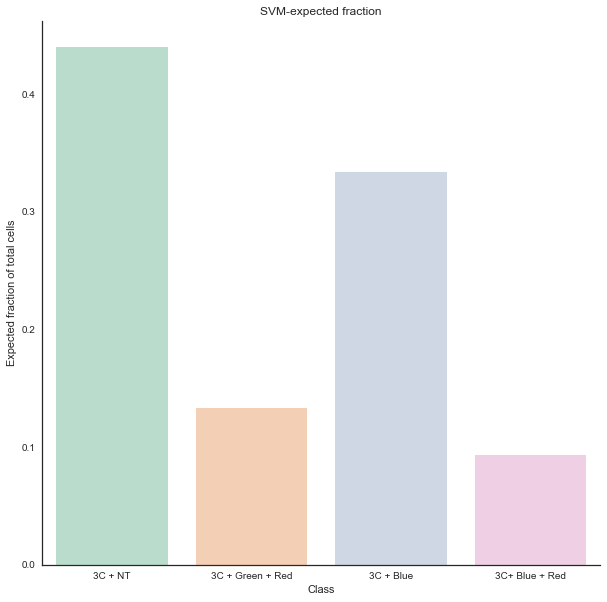

In [30]:
df_pred = pd.DataFrame({"y_pred" : y_pred,"y_test" : y_test})
df_pred2 = df_pred.groupby(['y_pred'])['y_test'].count()

fig, ax= plt.subplots(figsize = (10,10))
sns.barplot(x = df_pred2.index, y = df_pred2/sum(df_pred2), palette = 'Pastel2', order= ['3C + NT', '3C + Green + Red','3C + Blue','3C+ Blue + Red'])
plt.xlabel('Class')
plt.ylabel('Expected fraction of total cells')
plt.title('SVM-expected fraction')
sns.despine()
plt.savefig(folder + 'SVM_results.eps', type = 'eps')
plt.savefig(folder + 'SVM_results.png', type = 'png', dpi =300)

### plot measured fractions

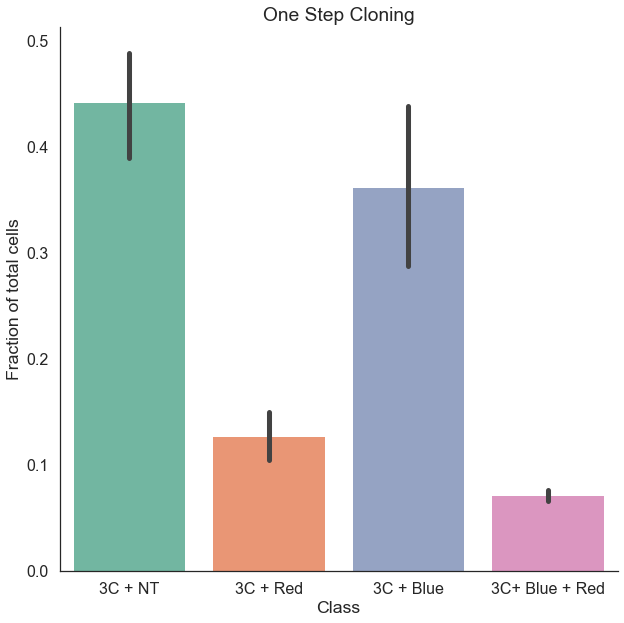

In [73]:
## count cells in random

df_rand = df3[df3["Name"].isin(["3C_onestep"])]
df_rand.dropna(inplace=True)
df_rand["y_pred"] = svclassifier.predict(X_rand)
X_rand = df_rand.loc[:,['logBV 421-A', 'logPE-CF594-A']]
df_rand2 = df_rand.groupby(['Name', 'WellName', 'y_pred'])['Info'].count()
df_rand2 = df_rand2.reset_index()

df_rand2['total']=0
for ii in df_rand2['Name'].unique():
    for jj in df_rand2['WellName'].unique():
        df_rand2.loc[(df_rand2['Name']==ii) & (df_rand2['WellName']==jj), 'total' ] = df_rand2.loc[(df_rand2['Name']==ii) & (df_rand2['WellName']==jj), 'Info'].sum()
df_rand2['fraction'] = df_rand2['Info']/df_rand2['total']

#plot fractions

fig, ax= plt.subplots(figsize = (10,10))

sns.barplot(x = df_rand2['y_pred'], y = df_rand2['fraction'],ci =95, palette = 'Set2', order= ['3C + NT', '3C + Red','3C + Blue','3C+ Blue + Red'])
plt.xlabel('Class')
plt.ylabel('Fraction of total cells')
plt.title('One Step Cloning')
sns.despine()
plt.savefig(folder + 'Onestep_results.eps', type = 'eps')
plt.savefig(folder + 'Onestep_results.png', type = 'png', dpi =300)